# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys

%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [46]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg

In [56]:
from importlib import reload

In [59]:
import setsum_layer
reload(setsum_layer)
from setsum_layer import MaskedDense, MaskedSum

## Data Preparation

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [7]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
tst_comorb = pd.read_csv(path+'cohorts/ami/comorb_tst.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(tst_comorb['KEY_NRD'])]

N_train = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, tst_comorb)

In [8]:
train_df.to_csv(path+'cohorts/ami/DX_train.csv', index=False)
tst_df.to_csv(path+'cohorts/ami/DX_tst.csv', index=False)

In [76]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df = pd.read_csv(path+'all/DXs_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'all/DXs_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [9]:
all_df = pd.concat([train_df, tst_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [10]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series[DX_series.isin(['invl', 'incn'])] = 'missing'

In [11]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [12]:
unclassified = set(multi_ccs.loc[multi_ccs.CCS_LVL1 == '18', 'ICD9CM_CODE'])
DX_series.loc[DX_series.isin(unclassified)] = 'missing'

In [13]:
rare_cutpoint = 10
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'missing' # also consider coding as 'rare'

In [14]:
DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [15]:
n_DX_cat

2378

In [16]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

In [17]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## LSTM with Raw ICD9 codes

In [16]:
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values
DX_mat_trn = DX_df.values[:N_trn, ]
DX_mat_val = DX_df.values[N_trn:, ]

In [20]:
DX_ohe = np.zeros((len(train_df), n_DX_cat))

for j in range(DX_mat.shape[0]):
    for i in range(DX_mat.shape[1]):
        DX_ohe[j, DX_mat[j, i]] = 1

DX_ohe_trn = DX_ohe[:N_trn, ]
DX_ohe_val = DX_ohe[N_trn:, ]

In [17]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [18]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [19]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [20]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

### Model Building with Embedding

In [21]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [146]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=n_DX_cat, output_dim=DX_embed_dim, input_length=N_DX)(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False)(DX_embed)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 29, 50)       266400      input_17[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 1)         869         input_20[0][0]                   
__________________________________________________________________________________________________
input_18 (

In [147]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [148]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_lstm_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_lstm_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [149]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [150]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 3s 23us/step - loss: 1.3184 - acc: 0.6007 - val_loss: 0.6395 - val_acc: 0.5991
AUC: 0.6896

Epoch 2/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2609 - acc: 0.6178 - val_loss: 0.6346 - val_acc: 0.6035
AUC: 0.6955

Epoch 3/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2497 - acc: 0.6205 - val_loss: 0.6506 - val_acc: 0.5970
AUC: 0.6957

Epoch 4/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2427 - acc: 0.6249 - val_loss: 0.6191 - val_acc: 0.6244
AUC: 0.6966

Epoch 5/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2401 - acc: 0.6250 - val_loss: 0.5905 - val_acc: 0.6412
AUC: 0.6957

Epoch 6/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2357 - acc: 0.6234 - val_loss: 0.6054 - val_acc: 0.6371
AUC: 0.6947

Epoch 7/20
145667/145667 [===========

### Model testing

In [151]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

In [34]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [35]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [36]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [152]:
model.load_weights(model_path+'ami_icd9_lstm_auc1.h5')

In [153]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 58us/step


{0: 0.7063960981175992}

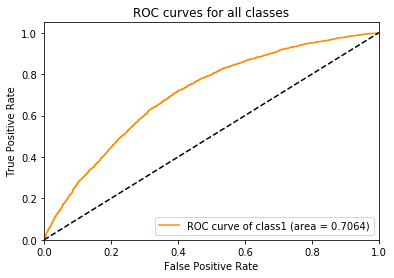

In [155]:
plot_roc(y_pred, y_true)

## Multi-Level CCS Codes

### Define the parent matrix

Read the ICD9 CCS multi-level category dictionary file. 

In [23]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

In [18]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [21]:
multi_ccs.shape

(15072, 5)

In [23]:
multi_ccs.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

Create one list to store all possible ICD9 code and their CCS multi-level in a list. Creat two dataframe to store the parent of each code and the indices of the parent. 

In [19]:
ami_ccs = multi_ccs.loc[multi_ccs.ICD9CM_CODE.isin(DX_cat)]

In [19]:
ami_ccs.shape

(3014, 5)

In [20]:
ccs_cat = pd.concat([ami_ccs.CCS_LVL1, ami_ccs.CCS_LVL2, ami_ccs.CCS_LVL3, ami_ccs.CCS_LVL4]).astype('category').cat.categories

In [165]:
len(ccs_cat)

562

In [21]:
all_codes = [DX_cat[-1]]+list(DX_cat[:-1]) + list(ccs_cat[1:])

In [22]:
len(all_codes)

2938

In [23]:
ami_ccs = ami_ccs.set_index(ami_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)

ami_ccs['finest_non_empty'] = ami_ccs.CCS_LVL4
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL3[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL2[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL1[ami_ccs.finest_non_empty == '']

DX_parent = ami_ccs[['finest_non_empty']]

DX_parent.columns = ['parent_code']

DX_parent = DX_parent.assign(parent_index=DX_parent.parent_code.apply(lambda x:all_codes.index(x)).values)

DX_parent = DX_parent.append(pd.DataFrame(index=['missing'], data=dict(parent_code = ['NA'], 
                                                                                       parent_index=[-1])))

In [24]:
CCS_parent = pd.DataFrame(dict(CCS_code=ccs_cat[1:]))

CCS_parent = CCS_parent.assign(parent_code=CCS_parent.CCS_code.apply(lambda x:'.'.join(x.split('.')[:-1])))

def get_CCS_ind(code):
    try:
        ind = all_codes.index(code)
    except ValueError:
        ind = -1
    return ind
CCS_parent = CCS_parent.assign(parent_index=CCS_parent.parent_code.apply(get_CCS_ind).values)

CCS_parent = CCS_parent.set_index(CCS_parent.CCS_code, drop=True).drop(['CCS_code'], axis=1)

In [62]:
CCS_parent

,parent_code,parent_index
CCS_code,,
1,,-1
1.1,1,3015
1.1.1,1.1,3016
1.1.2,1.1,3016
1.1.2.1,1.1.2,3018
1.1.2.2,1.1.2,3018
1.1.2.3,1.1.2,3018
1.1.2.4,1.1.2,3018
1.1.2.5,1.1.2,3018


In [63]:
DX_parent

,parent_code,parent_index
01190,1.1.1,3017
V1201,1.1.1,3017
0380,1.1.2.1,3019
03810,1.1.2.2,3020
03811,1.1.2.2,3020
03812,1.1.2.2,3020
03819,1.1.2.2,3020
03842,1.1.2.3,3021
03840,1.1.2.4,3022
03841,1.1.2.4,3022


In [25]:
parent_df = pd.concat([DX_parent, CCS_parent], axis=0)

In [26]:
parent_mat = np.identity(len(all_codes))

In [27]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -1

In [26]:
no_parent = np.where(parent_mat.sum(axis=1)>0)[0]

In [27]:
np.array(all_codes)[no_parent]

array(['missing', '1', '10', '11', '12', '13', '14', '16', '17', '2', '3',
       '4', '5', '6', '7', '8', '9'], dtype='<U9')

In [28]:
parent_mat = parent_mat[parent_mat.sum(axis=1)==0, :]

In [29]:
parent_mat.shape

(2921, 2938)

In [36]:
np.save(path+'cohorts/ami/parent_mat3.npy', parent_mat) #code freq >= 5, no CCS cat 18

### Data Formatting

In [145]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

In [147]:
train_df.shape

(163552, 150)

In [146]:
train_df = train_df[(DX_df=='missing').sum(axis=1)<29].reset_index(drop=True)

In [30]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])

In [31]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values

DX_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]

In [32]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [33]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [34]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [35]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [36]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [37]:
DX_embed_dim = 36
hosp_embed_dim = 3

In [37]:
parent_mat = np.load(path+'cohorts/ami/parent_mat3.npy')

In [34]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=parent_mat.shape[1], output_dim=DX_embed_dim, mask_zero=True,
                     embeddings_regularizer=Mat_reg(parent_mat, 0.001, norm=1), name='DX_embed')(input_DX)
DX_feature = SetSum(DX_embed_dim, activation='tanh')(DX_embed)
#DX_feature = MaskedSum()(DX_embed)

input_demo = Input(shape=(2, ))
input_DX1 = Input(shape=(len(DX1_cat),))
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(32, activation='relu')(merged)
x = Dropout(0.2)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [38]:
input_demo = Input(shape=(2, ))
input_DX1 = Input(shape=(len(DX1_cat),))
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
merged = concatenate([input_demo, input_DX1, hosp_embed], axis=1)

merged = RepeatVector(N_DX)(merged)

input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=parent_mat.shape[1], output_dim=DX_embed_dim, mask_zero=True,
                     embeddings_regularizer=Mat_reg(parent_mat, 0.001, norm=2), name='DX_embed')(input_DX)

feature = Concatenate()([DX_embed, merged])
feature = MaskedDense(DX_embed_dim, activation='relu')(feature)
feature = MaskedSum()(feature)
x = Dense(32, activation='relu')(feature)
x = Dropout(0.2)(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [66]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [67]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_ccs_masksum_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_ccs_masksum_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [68]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [69]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=256, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 8s 56us/step - loss: 1.6406 - val_loss: 0.6854
AUC: 0.6860

Epoch 2/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.3293 - val_loss: 0.6576
AUC: 0.7032

Epoch 3/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2916 - val_loss: 0.6389
AUC: 0.7072

Epoch 4/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2749 - val_loss: 0.6366
AUC: 0.7086

Epoch 5/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2661 - val_loss: 0.6157
AUC: 0.7104

Epoch 6/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2571 - val_loss: 0.6262
AUC: 0.7119

Epoch 7/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2495 - val_loss: 0.6204
AUC: 0.7129

Epoch 8/20
145667/145667 [==============================] - 3s 20us/step - loss: 1.2429 - val_loss: 0.6197
AU

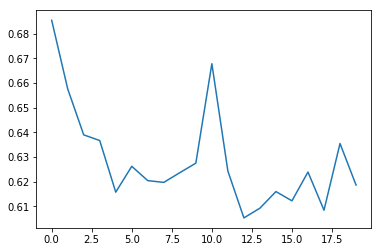

In [70]:
plt.plot(hist.history['val_loss'])

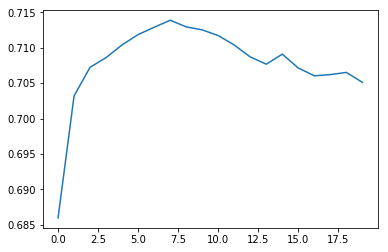

In [71]:
plt.plot(auccheckpoint.auc_history)

### Model testing

In [72]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

In [73]:
tst_df = tst_df[(DX_df_tst == 'missing').sum(axis=1)<29]

In [77]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

DX_mat_tst.sort(axis=1)
#DX_mat_tst = DX_mat_tst[:, ::-1]

In [78]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [79]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [80]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [81]:
model.load_weights(model_path+'ami_ccs_masksum_auc1.h5')

In [82]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 29us/step


{0: 0.7035921250440211}

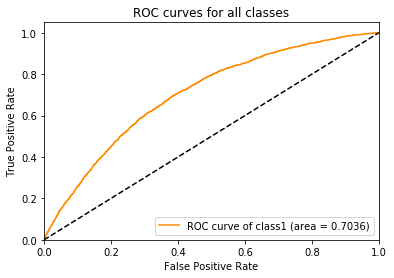

In [83]:
plot_roc(y_pred, y_true)

In [95]:
embed_mat = model.layers[2].get_weights()[0]

In [88]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:30]

array([0.19206613, 0.18525071, 0.19214025, 0.22261131, 0.21991327,
       0.21312036, 0.21395865, 0.18042475, 0.23263112, 0.20849742,
       0.2171706 , 0.221458  , 0.20803829, 0.18642162, 0.18367086,
       0.19607946, 0.19855969, 0.19378251, 0.23564704, 0.20976073,
       0.20245887, 0.2339789 , 0.18185973, 0.22081879, 0.20342825,
       0.1960982 , 0.19690487, 0.19222978, 0.19159055, 0.20484276],
      dtype=float32)

In [96]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:30]

array([0.19206613, 0.05574033, 0.05200075, 0.05206684, 0.06145821,
       0.09432068, 0.05461602, 0.03741015, 0.05191894, 0.03062067,
       0.04970593, 0.05317962, 0.05420603, 0.03656052, 0.04274737,
       0.04807642, 0.05005065, 0.04716379, 0.04575374, 0.03864745,
       0.03666022, 0.03635335, 0.03762525, 0.04590897, 0.03675134,
       0.03597372, 0.03329653, 0.05921885, 0.06657047, 0.05399343],
      dtype=float32)

In [87]:
ami_ccs.head()

,ICD9CM_CODE,CCS_LVL1,CCS_LVL2,CCS_LVL3,CCS_LVL4
91,01190,1,1.1,1.1.1,
425,V1201,1,1.1,1.1.1,
426,0380,1,1.1,1.1.2,1.1.2.1
428,03810,1,1.1,1.1.2,1.1.2.2
429,03811,1,1.1,1.1.2,1.1.2.2


In [66]:
np.linalg.norm(np.dot(parent_mat, embed_mat), axis=1, ord=2)[:20]

array([0.01805247, 0.01935255, 0.03103866, 0.00956126, 0.14596854,
       0.01274131, 0.10231429, 0.02529758, 0.02614069, 0.02074293,
       0.03423172, 0.02106512, 0.02336136, 0.04806978, 0.02870569,
       0.06002716, 0.03298613, 0.02912723, 0.02108174, 0.01832154])

In [74]:
from sklearn import decomposition, manifold

In [75]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [76]:
embed_tsne = tsne.fit_transform(embed_mat[1:(n_DX_cat-2),:])

In [77]:
ccs_lvl1 = [ami_ccs.loc[c, 'CCS_LVL1'] for c in all_codes[1:(n_DX_cat-2)]]

fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [78]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [79]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

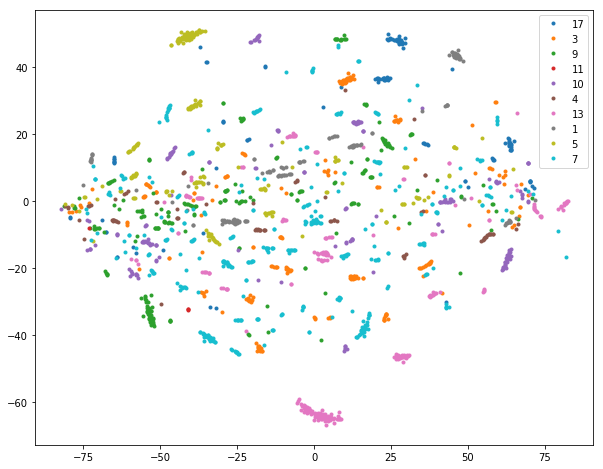

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [90]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index

plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

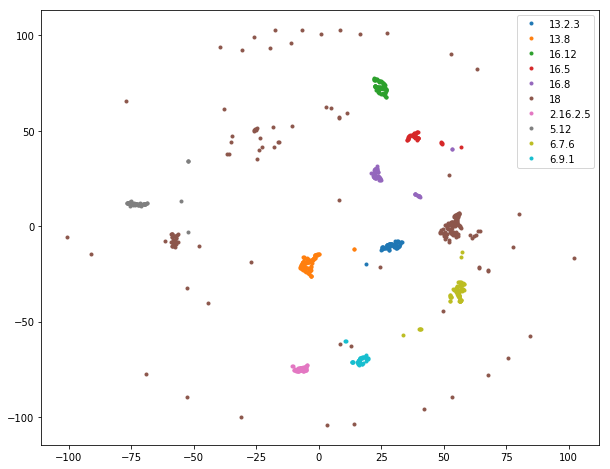

In [91]:
groups = plot_subdf.groupby('fine_group')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [153]:
plot_subdf = plot_df.loc[plot_df.lvl1=='3']

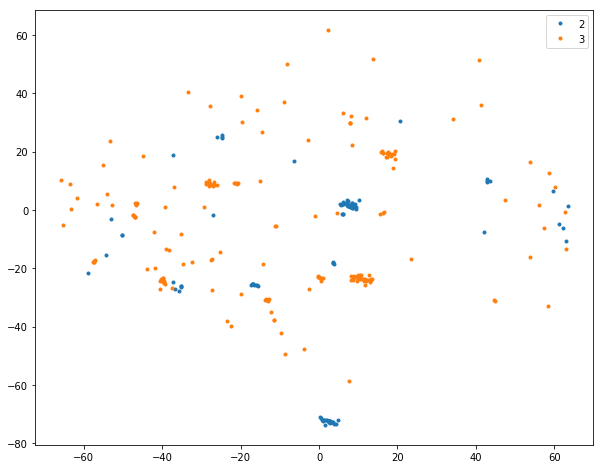

In [154]:
groups = plot_subdf.groupby('level')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [108]:
top_fine_cat

Index(['18', '13.8', '6.7.6', '16.12', '13.2.3', '16.8', '5.12', '6.9.1',
       '16.5', '2.16.2.5', '9.12.3', '16.10.2.7', '1.1.4', '9.2', '3.11.3',
       '3.4', '16.6.1', '17.1.9', '8.9', '10.1.8.3'],
      dtype='object')

### Hyper Tuning

In [68]:
with open('output/hyper_tune_nomask.csv', 'a') as f:
    f.write('DX_dim,hosp_dim,penalty,fc_width,dropout,lr,batch_size,auc\n')

In [27]:
col_names = ['DX_dim', 'hosp_dim', 'penalty', 'fc_width', 'dropout', 'lr', 'batch_size', 'auc']

In [28]:
hp = pd.read_csv('output/hyper_tune_nomask_no18.csv', names=col_names)

In [24]:
len(hp)

91

In [30]:
hp.loc[hp.auc>0.709]

,DX_dim,hosp_dim,penalty,fc_width,dropout,lr,batch_size,auc
18,20,2,0.000874,32,0.267511,0.0002,256,0.7093
24,27,2,0.000295,64,0.143071,0.0002,128,0.7092
56,28,3,0.000079,64,0.245499,0.0005,256,0.7092
67,24,1,0.000003,64,0.043036,0.0005,256,0.7094


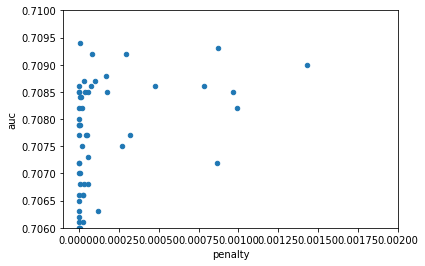

In [31]:
hp.plot.scatter('penalty', 'auc', xlim=(-0.0001, 0.002), ylim=(0.706, 0.71))

### Backups

### Model Building with OHE

In [20]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [55]:
input_DX = Input(shape = (n_DX_cat,))
DX_feature = Dense(DX_embed_dim, use_bias=False)(input_DX)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [56]:
DX_feature.shape

TensorShape([Dimension(None), Dimension(50)])

In [58]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_ohe_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_ohe_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [60]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [61]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
 - 7s - loss: 1.3245 - acc: 0.5939 - val_loss: 0.6438 - val_acc: 0.6399
AUC: 0.6854

Epoch 2/20
 - 9s - loss: 1.2781 - acc: 0.6356 - val_loss: 0.6329 - val_acc: 0.6380
AUC: 0.6898

Epoch 3/20
 - 9s - loss: 1.2583 - acc: 0.6404 - val_loss: 0.6276 - val_acc: 0.6399
AUC: 0.6901

Epoch 4/20
 - 9s - loss: 1.2450 - acc: 0.6460 - val_loss: 0.6301 - val_acc: 0.6279
AUC: 0.6871

Epoch 5/20
 - 9s - loss: 1.2293 - acc: 0.6470 - val_loss: 0.6398 - val_acc: 0.6230
AUC: 0.6841

Epoch 6/20
 - 9s - loss: 1.2162 - acc: 0.6539 - val_loss: 0.6214 - val_acc: 0.6377
AUC: 0.6814

Epoch 7/20
 - 9s - loss: 1.2016 - acc: 0.6574 - val_loss: 0.6104 - val_acc: 0.6439
AUC: 0.6778

Epoch 8/20
 - 9s - loss: 1.1875 - acc: 0.6590 - val_loss: 0.6120 - val_acc: 0.6417
AUC: 0.6747

Epoch 9/20
 - 9s - loss: 1.1727 - acc: 0.6650 - val_loss: 0.6097 - val_acc: 0.6387
AUC: 0.6750

Epoch 10/20
 - 9s - loss: 1.1610 - acc: 0.6660 - val_loss: 0.6189 - val_acc: 0.6329
A